In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1kl65YOvoSAMSgszQQbua2q4Zwe1HgPct
!unzip -o "data.zip"  -d  "/content"

movie_10k_df = pd.read_csv("movies_min.csv")
amazon_df =pd.read_csv('amazon_min.csv')
book_df=pd.read_csv("book_min.csv")
food_df = pd.read_csv('food_min.csv')
ecommerce_df=pd.read_csv('ecom_min.csv')
ciao_df=pd.read_csv('ciao_min.csv')
amazon_df=amazon_df[['userID',	'itemID',	'rating','time']]


Downloading...
From: https://drive.google.com/uc?id=1kl65YOvoSAMSgszQQbua2q4Zwe1HgPct
To: /content/data.zip
100% 4.16M/4.16M [00:00<00:00, 171MB/s]
Archive:  data.zip
  inflating: /content/amazon_min.csv  
  inflating: /content/book_min.csv   
  inflating: /content/ciao_min.csv   
  inflating: /content/ecom_min.csv   
  inflating: /content/food_min.csv   
  inflating: /content/movies_min.csv  


# Popularity Based recommendation

### Avarage rating

In [ ]:
avg_rating_df = amazon_df.groupby('itemID').mean()['rating'].reset_index()
avg_rating_df.rename(columns={'rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)

,itemID,avg_rating
2770,B00L3YHF6O,5.0
712,B001TH7GUA,5.0
1973,B007SZ0E1K,5.0
1919,B007FH1KX2,5.0
52,B00006HSML,5.0
645,B001N9X4CS,5.0
1140,B003N8GVUY,5.0
1894,B0076W9Q5A,5.0
2660,B00FZ9SMVU,5.0
1506,B004UTQRHW,5.0


### Total rating count

In [ ]:
total_rating_df = amazon_df.groupby('itemID').count()['rating'].reset_index()
total_rating_df.rename(columns={'rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)

,itemID,num_ratings
1986,B007WTAJTO,288
2035,B0088CJT4U,275
1083,B003ES5ZUU,268
309,B000N99BBC,219
2017,B00829TIEK,199
954,B002V88HFE,185
2013,B00829THK0,173
978,B002WE6D44,167
2060,B008DWCRQW,162
2246,B009SYZ8OC,161


In [ ]:
popular_list = total_rating_df.merge(avg_rating_df,on='itemID')
popular_list.sort_values(['avg_rating','num_ratings'], ascending=[False,False]).head(10)

,itemID,num_ratings,avg_rating
1725,B005LDLP8W,25,5.0
1973,B007SZ0E1K,24,5.0
2695,B00HG1L334,23,5.0
1006,B0033PRWSW,20,5.0
712,B001TH7GUA,19,5.0
2713,B00HZWJGS8,18,5.0
2731,B00ISFNSBW,18,5.0
1894,B0076W9Q5A,17,5.0
2382,B00BLCVD9I,16,5.0
2739,B00IVPU6AA,16,5.0


### Plot the simple mean against the number of reviews 

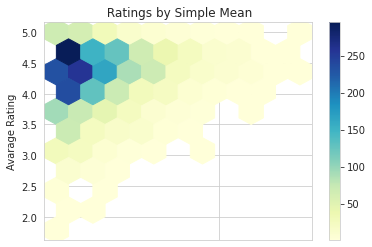

In [ ]:
grid   = pd.DataFrame({
                    'Avarage Rating': popular_list['avg_rating'],
                    'Number of Reviewers': popular_list['num_ratings']
                 })
grid.plot(x='Number of Reviewers', y='Avarage Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=10, mincnt=1,
                  title=" Ratings by Simple Mean")
plt.show()


This figure shows that the average rating of a movie is actually slightly Lesser than 3

 ### Bayesian Adjustment Rating
 https://www.analyticsvidhya.com/blog/2019/07/introduction-online-rating-systems-bayesian-adjusted-rating/

In [ ]:
bayes_adj_df=popular_list
bayes_adj_df['total']=bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating']

In [ ]:
total=bayes_adj_df['total'].sum()
total_views=bayes_adj_df['num_ratings'].sum()

In [ ]:
bayes_adj_df['bayes_rating']=((bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating'])+total)/((bayes_adj_df['num_ratings']+total_views))

In [ ]:
bayes_adj_df.sort_values(['bayes_rating'], ascending=[False]).head(10)

,itemID,num_ratings,avg_rating,total,bayes_rating
1083,B003ES5ZUU,268,4.850746,1300.0,4.314814
1986,B007WTAJTO,288,4.684028,1349.0,4.314253
309,B000N99BBC,219,4.767123,1044.0,4.314142
501,B0019EHU8G,153,4.823529,738.0,4.313822
978,B002WE6D44,167,4.760479,795.0,4.313770
954,B002V88HFE,185,4.691892,868.0,4.313700
714,B001TH7GUU,123,4.869919,599.0,4.313677
338,B000QUUFRW,128,4.765625,610.0,4.313518
390,B000VX6XL6,122,4.762295,581.0,4.313470
1354,B004CLYEDC,139,4.683453,651.0,4.313420


# Colaborative Filtering

### Prepare dataset

In [ ]:
amazon_df.head(1)

,userID,itemID,rating,time
0,A2GP6XJ1V3MM3L,1400532655,5.0,1303344000


In [ ]:
final_ratings=amazon_df.sort_values(by=['userID','rating'], ascending=[False,False]) 
final_ratings.shape

(66149, 4)

### Collaborative filtering

In [ ]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
features_df = final_ratings.pivot_table(
    index='itemID',
    columns='userID',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix

In [ ]:
features_df

userID,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A107CTGSINY3GJ,A108XABRHAA9E7,A10AFVU66A79Y1,A10B6G6W3DW1EY,A10C5CJK1YKGV0,A10CRW7XRJBJ2G,...,AZE2ZP618W1EP,AZFF4CX9MQ4AE,AZG6CV3B3279V,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ,AZQGJ5CEAJGXB,AZV2U6GU5QA6C,AZYJE40XW6MFG,AZZ2DEE2NTIM7
itemID,,,,,,,,,,,,,,,,,,,,,
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000J1V5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000K135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00001P4XA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00001P4XH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00KNM763E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00L21HC7A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
B00L2442H0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply nearest neighbour Algorithms

In [ ]:
from scipy.sparse import csr_matrix

features_df_matrix = csr_matrix(features_df.values)

from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
amazon_df[amazon_df['itemID']=='B00000J1V5'].head(1)

,userID,itemID,rating,time
13,A105TOJ6LTVMBG,B00000J1V5,4.0,1367020800


In [ ]:
query_index = features_df.index.get_loc('B00000J1V5')
#print(query_index)

distances, indices = model.kneighbors(features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 9)
indices=list(indices.flatten())

indices.remove(query_index)
indices

[238, 224, 336, 2340, 22, 273, 44, 35]

In [ ]:

amazon_df[(amazon_df['itemID'].isin(features_df.index[indices]))].groupby('itemID').head(1)

,userID,itemID,rating,time
497,A1VLE2SH9J8WYS,B0000510ZO,5.0,1315872000
723,A2EOLXPGVSYTY8,B00005T3G0,5.0,1384473600
968,A2EOLXPGVSYTY8,B000067S60,5.0,1384473600
5022,A3CW0ZLUO5X2B1,B000ENUCR4,5.0,1341014400
5285,A2HMF8ZR67BNZS,B000F0ELOG,5.0,1350864000
6052,A12EVK82QUTSA6,B000I23TTE,5.0,1387152000
7825,AFXTKAO0CB354,B000Q85WRC,5.0,1255219200
56208,A3BMUBUC1N77U8,B00B46XUQU,3.0,1386979200


In [ ]:
bayes_adj_df[(bayes_adj_df['itemID'].isin(features_df.index[indices]))].groupby('itemID').head(1)

,itemID,num_ratings,avg_rating,total,bayes_rating
22,B0000510ZO,18,4.777778,86.0,4.312769
35,B00005T3G0,47,4.574468,215.0,4.312829
44,B000067S60,16,4.687500,75.0,4.312733
224,B000ENUCR4,23,4.869565,112.0,4.312836
238,B000F0ELOG,19,4.736842,90.0,4.312764
273,B000I23TTE,20,4.500000,90.0,4.312699
336,B000Q85WRC,15,5.000000,75.0,4.312799
2340,B00B46XUQU,63,4.111111,259.0,4.312451
